Simulate the energy prices using the options with Monte Carlo distribution.



---


#Step 0: importing libraries


---



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy.stats import norm
from numpy.random import rand

# Step 1: Introduction

In this notebook, we are going to exploit the concept of Monte Carlo simulation by using the price of a given electricity option.

In order to model the price paths, we need to go in depth of some stochastic processes that are able to take into account the important features of this market.

First we have:
- **Mean-reverting behaviour**: This should be modelled using the Ornstein-Uhlenbeck process, which accounts for parameters like $κ$ and $\theta$. The first is the speed of reversion to the mean, and the second is the long-term behaviour.
- **Seasonality**: The energy market has times when demand can spike and others when it experiences a downturn. It is strongly connected to factors like weather, macroeconomic situations (inflation, GDP), geopolitics (OPEC, war, regulations), coal prices, and natural gas prices. The seasonal shape could be added using a sinusoidal pattern, but for now, we will omit it.
- **Storage costs**: This is another important factor that affects seasonality and, subsequently, supply. High storage costs push the supply lower (and vice-versa). If the supply goes lower and demand remains stable, we expect prices to increase. This is strongly connected to the forward curve: when forward prices are higher than spot prices, it often indicates an expectation of higher storage costs in the future.
This should be included in the option calculation, modifying the Black-Scholes model to obtain **Black '76**.

# Step 2: Simulation with Monte Carlo and the Schwartz Model

## Understanding Monte Carlo Simulation

**Monte Carlo simulation** is a broad class of computational algorithms that rely on repeated random sampling to obtain numerical results. The fundamental idea is to use randomness to solve problems that might be deterministic in principle. It's especially powerful for problems with many coupled degrees of freedom or when analytical solutions are intractable.

In finance, Monte Carlo simulations are extensively used for:
*   **Option pricing:** Estimating the value of complex options (e.g., path-dependent options) by simulating thousands or millions of possible future price paths of the underlying asset.
*   **Risk management:** Calculating Value at Risk (VaR) or Conditional Value at Risk (CVaR) for portfolios by simulating potential market movements.
*   **Financial modeling:** Projecting future cash flows, company valuations, or economic scenarios under various probabilistic assumptions.

**How it works (for option pricing):**
1.  **Define the underlying process:** Choose a stochastic process (like Geometric Brownian Motion or the Schwartz model for energy) that describes how the asset's price evolves over time.
2.  **Generate random paths:** Simulate a large number (N) of possible future price paths for the underlying asset from the current time up to the option's expiration. Each path is generated by drawing random numbers from a specified distribution.
3.  **Calculate payoff for each path:** For each simulated path, determine the option's payoff at expiration.
4.  **Average the payoffs:** Sum all the individual payoffs and divide by the number of paths (N) to get the expected payoff.
5.  **Discount to present value:** Discount this expected payoff back to today using the risk-free interest rate to get the Monte Carlo estimate of the option's price.

The **Schwartz model (1997)** is widely used for energy prices. It's a two-factor model:

$$
\begin{cases}
dx_t = \mu dt + \sigma_x dW^x_t \\
dy_t = \kappa(\theta - y_t)dt + \sigma_y dW^y_t \\
\ln S_t = x_t + y_t
\end{cases}
$$

*   $x_t$: non-stationary long-term factor (drift-dominated), representing broad market trends.
*   $y_t$: mean-reverting short-term factor, capturing temporary price spikes and dips that revert to a mean.
*   $\ln S_t$: log of spot price, meaning the spot price is the exponentiation of the sum of these two factors.
*   $W^x, W^y$: possibly correlated Brownian motions, driving the randomness in each factor.

### Properties:

*   **Captures short-term spikes** (via $y_t$) and **long-term trends** (via $x_t$)
*   Realistic for **electricity, oil, gas**, as it reflects both the long-term supply/demand fundamentals and the short-term volatility due to unexpected events.



In [2]:
# Model parameters
kappa = 1.0        # Mean reversion speed
theta = 0.0        # Long-term mean of X_t
mu = 0.05          # Drift of long-term component eta_t
sigma1 = 0.3       # Volatility of X_t (short-term)
sigma2 = 0.2       # Volatility of eta_t (long-term)
r = 0.01           # Risk-free rate

# Option parameters
S0 = 100              # Initial spot price
K = np.arange(1,20,1) # Strike price
T = 1.0               # Maturity in years
n_steps = 252         # Time steps (daily)
n_paths = 1000        # Monte Carlo paths


In [3]:
def monte_carlo_simulation(N,n_steps,T,S0,x0,theta,mu,sigma_x,kappa,sigma_y):

  '''It is a function that takes some parameters and performs the Monte Carlo
  simulation of the price path using the discretization of the Schwartz model,
  a useful model if we want to capture the mean reverting dynamic both in the
  short and long run.
  It returns x,y (stochastic differential equations) and the entire price
  simulation'''

  np.random.seed(52)
  dt=T/n_steps
  cov=[[1,0],[5,1]]
  epsilon = np.random.multivariate_normal([0, 0], cov, size=(N, n_steps))

  epsilon1 = epsilon[:, :, 0]  # shape: (N, n_steps)
  epsilon2 = epsilon[:, :, 1]
  y=np.zeros((N,n_steps+1))
  x=np.zeros((N,n_steps+1))
  S=np.zeros((N,n_steps+1))
  lnS=np.zeros((N,n_steps+1))
  S[:,0]=S0
  y[:,0]=np.log(S0)
  x[:,0]=x0
  lnS[:,0]=x[:,0]+y[:,0]
  for t in range(1,n_steps+1):
    y[:,t]=y[:,t-1]+kappa*(theta-y[:,t-1])*dt+sigma_y*np.sqrt(dt)*epsilon1[:,t-1]
    x[:,t]=x[:,t-1]+mu*dt+sigma_x*np.sqrt(dt)*epsilon2[:,t-1]
    lnS[:,t]=x[:,t]+y[:,t]
    S[:,t]=np.exp(lnS[:,t])

  return y,x,S

y,x,St=monte_carlo_simulation(n_paths,n_steps,T,S0,x0=0.15,theta=theta,mu=mu,sigma_x=sigma1,kappa=kappa,sigma_y=sigma2)

/tmp/ipython-input-3920959607.py:13: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  epsilon = np.random.multivariate_normal([0, 0], cov, size=(N, n_steps))


Let's inspect St.

In [4]:
St

array([[100.        , 110.96482333, 107.42794028, ...,   4.5604414 ,
          4.69211916,   4.49086968],
       [100.        , 107.86724579, 105.73270706, ...,   5.36430374,
          5.36974746,   5.15586152],
       [100.        , 114.5964349 , 112.81762352, ...,   8.60128352,
          7.81762502,   8.0246403 ],
       ...,
       [100.        , 115.38363152, 108.11458097, ...,   6.22134329,
          5.93025567,   5.98251355],
       [100.        , 111.04372004, 105.88645172, ...,   5.90354728,
          5.73003589,   5.39102455],
       [100.        , 115.19481562, 115.18723177, ...,  10.37071685,
         10.58358864,   9.67127386]])

###Plot 1

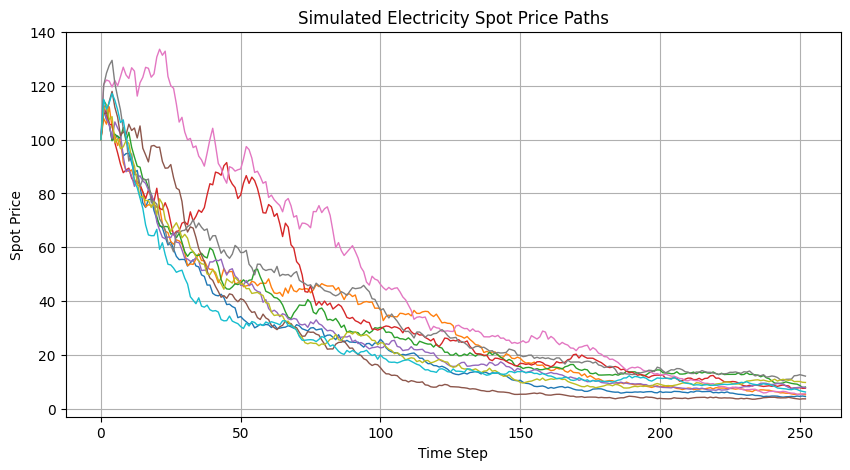

In [5]:
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.plot(St[i, :], lw=1)
plt.title("Simulated Electricity Spot Price Paths")
plt.xlabel("Time Step")
plt.ylabel("Spot Price")
plt.grid(True)
plt.show()

# Step 3: Option Prices

The Black-Scholes-Merton (BSM) model, with an adjustment for storage costs, is written in this way:

$$
C = S_0 \cdot e^{-cT} \cdot N(d_1) - K \cdot e^{-rT} \cdot N(d_2)
$$

Where:

*   $c$: storage cost (continuous rate)
*   $d_1 = \frac{\ln(S_0 / K) + (r - c + \frac{1}{2} \sigma^2)T}{\sigma \sqrt{T}}$
*   $d_2 = d_1 - \sigma \sqrt{T}$

We can also use the **Black '76 model**, which is particularly suited for commodity options or futures options, by substituting the spot price ($S_0$) with the forward price ($F_0$). This is because commodity options are often written on futures contracts, which are more liquid for future delivery than the physical spot market. The structure is very similar, replacing $S_0$ with $F_0$ and setting the dividend yield to the continuously compounded storage cost or convenience yield.

In [6]:
storage_costs=0.06/n_steps

In [7]:
def black_scholes_call(S0, K, T, r, sigma, storage_costs):
    d1 = (np.log(S0 / K) + (r - storage_costs + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S0 * np.exp(-storage_costs * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

The theoretical price of a European call option is:

$ = \mathbb{E}^{\mathbb{Q}}\!\left[ e^{-rT} \cdot (S_T - K)^+ \right]$

- $S_T $ = stock price at maturity
- $ K $ = strike price
- $r$ = risk-free rate
- $T$ = time to maturity
- $(x)^+ = \max(x, 0)$ = payoff function

Since the expectation cannot always be computed analytically, we **approximate it** with simulations:

1. Simulate many possible future stock prices $S_T$.
2. Compute the option payoff for each simulated price.
3. Discount it back to today.
4. Take the average across simulations.

As the number of simulations increases, the estimate converges to the true option price.


In [8]:
def option_pricing_all_paths(S, K, T, r):

    """
    S: simulated prices (n_paths, n_steps+1)
    K: array of strike prices (len K)
    Returns: option prices for each simulation and each strike (n_paths, len(K))
    """

    S_T = S[:, -1]
    S_T_grid, K_grid = np.meshgrid(S_T, K)
    payoff=  np.exp(-r * T) * np.maximum(S_T_grid - K_grid, 0)
    price=[black_scholes_call(s,k,T,r,sigma1,storage_costs) for k in K for s in S_T]
    price=np.array(price).reshape(n_paths,len(K))
    montecarlo_price=np.mean(payoff,axis=0)
    return payoff,price,montecarlo_price

payoff,price_option,montecarlo_price=option_pricing_all_paths(St,K,T,r)
print(montecarlo_price)

[ 0.41496004  0.56168693  1.46929244  1.30241071  1.36460693  0.25545265
  0.67174741  3.49385678  2.21797835  0.84068457  0.87853832  9.48156133
  2.09743576  0.21804743  1.91645569  1.59130868  1.07737398  0.17156854
  2.14467496  6.26449043  0.50775776  0.60226566  0.32187159  1.03307678
  0.77620022  0.75245393  4.8014512   1.31640257  0.35993005  4.84457951
  0.38320282  1.62555013  0.76308071  0.42228761  2.22175625  0.43730387
  0.13256072  1.86270205  3.10591015  1.03505939  0.96748772  2.02054722
  1.25494852  3.94767222  1.20840662  1.43500222  0.70414893  1.14554281
  1.80180979  2.29502517  1.61817474  1.47123321  2.53821512  0.82291844
  3.74979241  1.87615359  0.88993369  0.84692948  0.33375591  0.38181363
  0.21588405  0.80613705  1.88519818  0.06700187  0.33671643  0.3433536
  0.45786249  0.20307498  1.5997033   1.21077346  8.89949899  0.72769285
  0.42372234  0.68973523  0.47155892  0.88764613  1.01380872  2.15153348
  3.13868721  0.83161575  1.30299931  1.06789312  0.

# Step 4: Variance Reduction

In **Monte Carlo simulations**, we estimate expectations (like option prices) by averaging over many random samples. However, these estimates can have high **variance**, meaning they're noisy and require many samples to be accurate.

**Variance reduction techniques** aim to reduce this variability so we can:

*   Use fewer samples
*   Get more accurate estimates
*   Improve computational efficiency

---

## 1. Antithetic Variates

Instead of using only random numbers $U$, we also use their **mirror** $1 - U$. The idea is that their errors cancel each other out.

Example:
If we simulate paths with $Z \sim \mathcal{N}(0,1)$, also simulate with $-Z$. The intuition is that if one path is unusually high, its antithetic counterpart will be unusually low, and vice versa. When averaged, these extreme outcomes tend to cancel out, bringing the overall average closer to the true expected value and reducing the variance of the estimate.

> This works well when the function (e.g., the option payoff) is **monotonic** with respect to the random input. For a simple call or put option, the payoff is monotonic with respect to the final asset price, which itself is generally monotonic with respect to the underlying random shocks.

---

## 2. Control Variates

### Detailed Explanation of Control Variates

The **Control Variates** technique is a powerful variance reduction method that utilizes a second variable (the "control variable") whose expected value is known and which is correlated with the variable we are trying to estimate.

Let $\hat{X}$ be our original Monte Carlo estimator for a quantity $X$ (e.g., the price of an option), which has an unknown expected value $E[\hat{X}]$.
Let $Y$ be a control variable. We require two things from $Y$:
1.  Its expected value, $E[Y]$, is known.
2.  It is correlated with $X$.

We then construct a new estimator $\hat{X}_{cv}$ as follows:

$$
\hat{X}_{cv} = \hat{X} + \lambda (Y - E[Y])
$$

Here's how it works:
*   If $X$ and $Y$ are positively correlated:
    *   If $\hat{X}$ overestimates $E[X]$, then $Y$ is likely to overestimate $E[Y]$. In this case, $(Y - E[Y])$ would be positive. By choosing a negative $\lambda$, we subtract a correction term, pulling $\hat{X}_{cv}$ closer to the true value.
    *   If $\hat{X}$ underestimates $E[X]$, then $Y$ is likely to underestimate $E[Y]$. In this case, $(Y - E[Y])$ would be negative. By choosing a negative $\lambda$, we add a correction term, pulling $\hat{X}_{cv}$ closer to the true value.
*   The optimal $\lambda$ minimizes the variance of $\hat{X}_{cv}$ and is given by:
$$
    \lambda^* = - \frac{\text{Cov}(\hat{X}, Y)}{\text{Var}(Y)}
$$
    In practice, $\text{Cov}(\hat{X}, Y)$ and $\text{Var}(Y)$ are often estimated from the same Monte Carlo simulation data.

**How does it reduce variance?**
The variance of the new estimator is:
$$
\text{Var}(\hat{X}_{cv}) = \text{Var}(\hat{X}) + \lambda^2 \text{Var}(Y) + 2\lambda \text{Cov}(\hat{X}, Y)
$$
Substituting $\lambda^*$ into this equation, we get:
$$
\text{Var}(\hat{X}_{cv}) = \text{Var}(\hat{X})(1 - \rho^2(\hat{X}, Y))
$$
where $\rho(\hat{X}, Y)$ is the correlation coefficient between $\hat{X}$ and $Y$.
Since $\rho^2$ is always between 0 and 1, the variance of the control variate estimator is always less than or equal to the variance of the original estimator, provided there is some correlation. The higher the absolute correlation, the greater the variance reduction.

**Application in Option Pricing:**
For pricing an option with Monte Carlo, a common control variate is the payoff of a similar option for which an analytical solution (like Black-Scholes) is known.
*   **$\hat{X}$**: The Monte Carlo estimate of the complex option's payoff (e.g., an Asian option).
*   **$Y$**: The Monte Carlo estimate of a simple European option's payoff (on the same underlying and maturity).
*   **$E[Y]$**: The Black-Scholes price of that simple European option (which is known analytically).

By using the analytically priced European option as a control variate, we can significantly reduce the variance of our Monte Carlo estimate for more complex options.

---

## 3. Stratified Sampling

Divide the domain of the random variables into **strata** (subintervals), and sample uniformly within each one. This ensures **representativeness** and reduces sampling noise by guaranteeing that all regions of the sample space are adequately covered.

> Think of it like sampling some values in each decile of a distribution rather than purely at random. If you're estimating the average height of a population, stratified sampling would involve ensuring you sample a certain number of people from each age group or gender, rather than just taking a purely random sample that might accidentally over-represent one group.

---

## 4. Quasi-Monte Carlo

Uses **low-discrepancy sequences** (Sobol, Halton, etc.) instead of truly random numbers. These sequences are designed to **fill the sample space more evenly** and uniformly than pseudo-random numbers. This leads to **faster convergence** (i.e., less error for a given number of samples) than standard Monte Carlo, especially for higher-dimensional problems.

> Instead of getting two points like `0.23, 0.89`, a Sobol sequence might give `0.25, 0.75` — more evenly spaced. While not truly random, they are carefully structured to explore the space efficiently.

In [9]:
def monte_carlo_antithetic_energy(n_paths, n_steps, T, S0, x0, theta, mu, sigma_x, kappa, sigma_y):

    '''This function applies the concept of antithetic variate to reduce the
    variability. We have found the antithetic for epsilon1 and epsilon2
    and done the simulation on the entire dataset concatenated.
    np.random.randn creates a stand norm distribution.'''

    np.random.seed(52)
    dt = T / n_steps
    half = n_paths // 2
    eps1 = np.random.randn(half, n_steps)
    eps2 = np.random.randn(half, n_steps)
    eps1_all = np.concatenate([eps1, -eps1], axis=0)
    eps2_all = np.concatenate([eps2, -eps2], axis=0)

    x = np.zeros((n_paths, n_steps+1))
    y = np.zeros((n_paths, n_steps+1))
    S = np.zeros((n_paths, n_steps+1))
    lnS = np.zeros((n_paths, n_steps+1))

    x[:, 0] = x0
    y[:, 0] = np.log(S0)
    lnS[:, 0] = x[:, 0] + y[:, 0]
    S[:, 0] = S0

    for t in range(1, n_steps+1):
        y[:, t] = y[:, t-1] + kappa * (theta - y[:, t-1]) * dt + sigma_y * np.sqrt(dt) * eps1_all[:, t-1]
        x[:, t] = x[:, t-1] + mu * dt + sigma_x * np.sqrt(dt) * eps2_all[:, t-1]
        lnS[:, t] = x[:, t] + y[:, t]
        S[:, t] = np.exp(lnS[:, t])

    return S


##Plot 2 after variance reduction

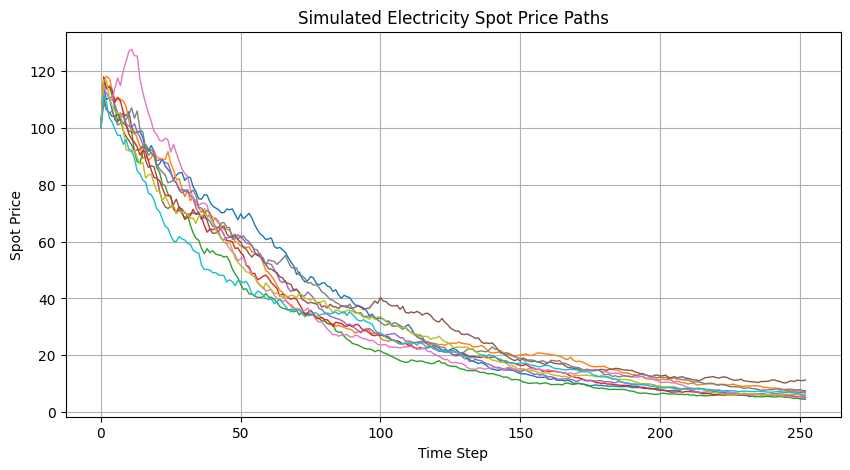

In [10]:
St_a = monte_carlo_antithetic_energy(n_paths, n_steps, T, S0, x0=0.15, theta=theta, mu=mu, sigma_x=sigma1, kappa=kappa, sigma_y=sigma2)
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.plot(St_a[i, :], lw=1)
plt.title("Simulated Electricity Spot Price Paths")
plt.xlabel("Time Step")
plt.ylabel("Spot Price")
plt.grid(True)
plt.show()

#Step 5: Option prices with Variance reduction

In [11]:
payoff_a,price_option_a,montecarlo_price_a=option_pricing_all_paths(St_a,K,T,r)
print(price_option)

[[3.49975075e+00 4.16458425e+00 7.03268006e+00 ... 5.95426883e+00
  2.10674283e+00 8.58082187e+00]
 [1.50199842e+01 3.94486392e+00 4.32029605e+00 ... 3.60692505e+00
  1.78131131e+00 7.97619358e+00]
 [1.04259023e+01 5.81895815e+00 5.60288215e+00 ... 1.15038160e+01
  8.00838250e+00 5.35488524e+00]
 ...
 [1.57375790e-03 5.00467547e-08 1.03783601e-04 ... 9.53503884e-02
  6.36325058e-11 3.55388373e-03]
 [3.66984568e-06 1.64216283e-08 4.24545177e-03 ... 1.01172886e-02
  1.98973506e-02 1.23072943e-05]
 [2.50518188e-05 7.38599405e-10 4.07614799e-05 ... 4.93620062e-05
  1.00848565e-05 1.85921235e-02]]


#Is the performance enhanced?

If the efficiency gain calculated below is greater than 1, the variance reduction helped a lot.

In this case, we are not satisfying from the result because it is basically 1, it means that the performance has not changed a lot.

In the option price, the performance has improved a lot.

This could be also connected to the number of samples we are considering, N=1000.

Keep in mind that adding an antithetic variable means to increase the space of parameters that we are considering and it increases the complexity as well.

So, it is true that we reduce variability, but the simulation becomes slower.

In [12]:
mean_plain = np.mean(St)
mean_anti = np.mean(St_a)

var_plain = np.var(St, ddof=1)
var_anti = np.var(St_a, ddof=1)

var_plain_op = np.var(montecarlo_price, ddof=1)
var_anti_op= np.var(montecarlo_price_a, ddof=1)


print("Efficiency gain Option:", (var_plain_op / var_anti_op).round(3))
print("Efficiency gain Stock:", (var_plain / var_anti).round(3))

Efficiency gain Option: 3.11
Efficiency gain Stock: 1.066
